In [1]:
%matplotlib inline
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets

import torch
import torch.autograd as agd
import torch.nn as tchnn
import torch.nn.functional as F
import torch.optim as optim
import random

import os, sys
sys.path.append(os.getcwd())

/home/udion/Misc/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
#some params
DIM = 512
FIXED_GEN = False
LAMBDA = .1
DISCRI_ITR = 5
BATCHSZ = 256
batchSz = BATCHSZ
TOT_GEN_ITR = 1001#100000

In [3]:
#gaussian mixture dataset creation
class GMMsampler:
    
    def __init__( self, n_samples, n_components=1, weights=[1], mu=[np.array([0,0])], sig=[np.array([[1,0],[0,1]])]):
        self.n_components = n_components
        self.n_samples = n_samples
        self.weights = weights
        self.mu = mu
        self.sig = sig
        self.dim = mu[0].size
        self.data = np.empty([n_samples, self.dim])
        self.datacid = dict()
        
    def check_musig(self):
        shmu = self.mu[0].shape
        shsig = self.sig[0].shape
        if(not(all(m.shape==shmu for m in mu))):
            print('all mean vectors must be of same dimension')
        if(not(all(s.shape==shmu for s in sig))):
            print('all covariance matrix must be of same dimension')
    
    def gen_sample(self):
        for i in range(self.n_components):
            self.datacid[i] = []
        for i in range(self.n_samples):
            idx = np.random.choice(np.arange(0,self.n_components), p=(self.weights)/np.sum(self.weights))
            mu_,sig_ = self.mu[idx], self.sig[idx]
            self.data[i,:] = np.random.multivariate_normal(mu_, sig_)
            self.datacid[idx].append(self.data[i,:])
        for idx in range(self.n_components):
            self.datacid[idx] = np.array(self.datacid[idx]).reshape(-1,2)
            
    def plot_centers(self):
        plt.figure()
        for c in self.mu:
            plt.scatter(c[0], c[1])
        plt.show()
        
    def plot_data(self):
        plt.figure()
        for i in range(self.n_components):
            plt.scatter(self.datacid[i][:,0], self.datacid[i][:,1])
        plt.show()

scale = 2
m1 = np.array([-1, 0])*scale
m2 = np.array([1, 0])*scale
m3 = np.array([0, 1])*scale
m4 = np.array([0, -1])*scale
m5 = np.array([1/np.sqrt(2), 1/np.sqrt(2)])*scale
m6 = np.array([1/np.sqrt(2), -1/np.sqrt(2)])*scale
m7 = np.array([-1/np.sqrt(2), 1/np.sqrt(2)])*scale
m8 = np.array([-1/np.sqrt(2), -1/np.sqrt(2)])*scale

sig1 = np.eye(2)/1.414
sig2 = np.eye(2)/1.414
sig3 = np.eye(2)/1.414
sig4 = np.eye(2)/1.414
sig5 = np.eye(2)/1.414
sig6 = np.eye(2)/1.414
sig7 = np.eye(2)/1.414
sig8 = np.eye(2)/1.414

In [4]:
#models of generator and discriminator
class Generator(tchnn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.L1 = tchnn.Linear(2, DIM)
        self.L2 = tchnn.Linear(DIM, DIM)
        self.L3 = tchnn.Linear(DIM, DIM)
        self.Ou = tchnn.Linear(DIM,2)
    def forward(self, noise, real_data):
        if FIXED_GEN:
            return noise + real_data
        else:
            x = F.relu(self.L1(noise))
            x = F.relu(self.L2(x))
            x = F.relu(self.L3(x))
            x = self.Ou(x)
            return x.view(-1,2)
    def name(self):
        return 'GENERATOR'

In [5]:
class Discriminator(tchnn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.L1 = tchnn.Linear(2, DIM)
        self.L2 = tchnn.Linear(DIM, DIM)
        self.L3 = tchnn.Linear(DIM, DIM)
        self.Ou = tchnn.Linear(DIM,1)
    def forward(self, x):
            x = F.relu(self.L1(x))
            x = F.relu(self.L2(x))
            x = F.relu(self.L3(x))
            x = self.Ou(x)
            return x.view(-1)
    def name(self):
        return 'DISCRIMINATOR'

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [13]:
#training data generator
def traindata_gen():
    g = GMMsampler(batchSz, n_components=8, weights=[1, 1, 1, 1, 1, 1, 1, 1],
                  mu=[m1,m2,m3,m4,m5,m6,m7,m8], sig=[sig1,sig2,sig3,sig4,sig5,sig6,sig7,sig8])
    while(True):
        g.gen_sample()
        #g.plot_centers()
        #g.plot_data()
        yield g.data
d = traindata_gen()

In [7]:
#gradient penalty term in objective
def calc_gp(D, real_data, fake_data):
    α = torch.rand(BATCHSZ, 1)
    α = α.expand(real_data.size())
    α = α.cuda()
    
    interpolated = α*real_data + (1-α)*fake_data
    interpolated = interpolated.cuda()
    interpolated = agd.Variable(interpolated, requires_grad=True)
    
    D_interp = D(interpolated)
    
    gradients = agd.grad(outputs=D_interp, inputs=interpolated, grad_outputs=torch.ones(D_interp.size()).cuda()
                        ,create_graph=True, retain_graph=True, only_inputs=True)[0]
    gp = ((gradients.norm(2, dim=1) - 1)**2).mean()*LAMBDA
    return gp

In [8]:
#notaion similar to paper
G = Generator().cuda()
D = Discriminator().cuda()
G.apply(weights_init)
D.apply(weights_init)
print(G)
print(D)

Generator (
  (L1): Linear (2 -> 512)
  (L2): Linear (512 -> 512)
  (L3): Linear (512 -> 512)
  (Ou): Linear (512 -> 2)
)
Discriminator (
  (L1): Linear (2 -> 512)
  (L2): Linear (512 -> 512)
  (L3): Linear (512 -> 512)
  (Ou): Linear (512 -> 1)
)


In [9]:
optD = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.9))
optG = optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.9))

In [10]:
one = torch.FloatTensor([1])
onebar = one * -1
one = one.cuda()
onebar = onebar.cuda()

In [11]:
#to plot results
def generate_image(true_dist):
    """
    Generates and saves a plot of the true distribution, the generator, and the
    critic.
    """
    N_POINTS = 128
    RANGE = 3

    points = np.zeros((N_POINTS, N_POINTS, 2), dtype='float32')
    points[:, :, 0] = np.linspace(-RANGE, RANGE, N_POINTS)[:, None]
    points[:, :, 1] = np.linspace(-RANGE, RANGE, N_POINTS)[None, :]
    points = points.reshape((-1, 2))

    points_v = agd.Variable(torch.Tensor(points), volatile=True).cuda()
    disc_map = D(points_v).cpu().data.numpy()

    noise = torch.randn(BATCHSZ, 2).cuda()
    
    noisev = agd.Variable(noise, volatile=True)
    
    true_dist_v = agd.Variable(torch.Tensor(true_dist).cuda())
    
    samples = G(noisev, true_dist_v).cpu().data.numpy()

    plt.clf()

    x = y = np.linspace(-RANGE, RANGE, N_POINTS)
    plt.contour(x, y, disc_map.reshape((len(x), len(y))).transpose())

    plt.scatter(true_dist[:, 0], true_dist[:, 1], c='orange', marker='+')
    if not FIXED_GEN:
        plt.scatter(samples[:, 0], samples[:, 1], c='green', marker='+')
    print('showing a graph')
    plt.show()

The GAN has 2 networks D and G, the training is done as follows,  the discriminator is trained first on the real data-set and then on the fake dataset, this would obviously mean that there will be backpropgation in the discriminator network, however when I'm training the generator I don't want the weights of the discriminators to change because the discrimantor will always adapt itself to tell generator is giving out fake and poor generator will never be able to catch up with D, hence when the generator is training discriminator is freezed

itr: 0 done
itr: 1 done
itr: 2 done
itr: 3 done
itr: 4 done
itr: 5 done
itr: 6 done
itr: 7 done
itr: 8 done
itr: 9 done
itr: 10 done
itr: 11 done
itr: 12 done
itr: 13 done
itr: 14 done
itr: 15 done
itr: 16 done
itr: 17 done
itr: 18 done
itr: 19 done
itr: 20 done
itr: 21 done
itr: 22 done
itr: 23 done
itr: 24 done
itr: 25 done
itr: 26 done
itr: 27 done
itr: 28 done
itr: 29 done
itr: 30 done
itr: 31 done
itr: 32 done
itr: 33 done
itr: 34 done
itr: 35 done
itr: 36 done
itr: 37 done
itr: 38 done
itr: 39 done
itr: 40 done
itr: 41 done
itr: 42 done
itr: 43 done
itr: 44 done
itr: 45 done
itr: 46 done
itr: 47 done
itr: 48 done
itr: 49 done
itr: 50 done
itr: 51 done
itr: 52 done
itr: 53 done
itr: 54 done
itr: 55 done
itr: 56 done
itr: 57 done
itr: 58 done
itr: 59 done
itr: 60 done
itr: 61 done
itr: 62 done
itr: 63 done
itr: 64 done
itr: 65 done
itr: 66 done
itr: 67 done
itr: 68 done
itr: 69 done
itr: 70 done
itr: 71 done
itr: 72 done
itr: 73 done
itr: 74 done
itr: 75 done
itr: 76 done
itr: 77 d

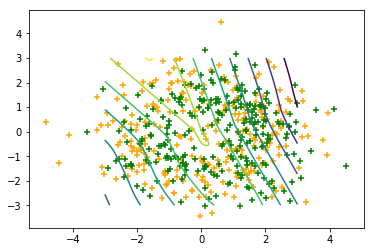

itr: 100 done
itr: 101 done
itr: 102 done
itr: 103 done
itr: 104 done
itr: 105 done
itr: 106 done
itr: 107 done
itr: 108 done
itr: 109 done
itr: 110 done
itr: 111 done
itr: 112 done
itr: 113 done
itr: 114 done
itr: 115 done
itr: 116 done
itr: 117 done
itr: 118 done
itr: 119 done
itr: 120 done
itr: 121 done
itr: 122 done
itr: 123 done
itr: 124 done
itr: 125 done
itr: 126 done
itr: 127 done
itr: 128 done
itr: 129 done
itr: 130 done
itr: 131 done
itr: 132 done
itr: 133 done
itr: 134 done
itr: 135 done
itr: 136 done
itr: 137 done
itr: 138 done
itr: 139 done
itr: 140 done
itr: 141 done
itr: 142 done
itr: 143 done
itr: 144 done
itr: 145 done
itr: 146 done
itr: 147 done
itr: 148 done
itr: 149 done
itr: 150 done
itr: 151 done
itr: 152 done
itr: 153 done
itr: 154 done
itr: 155 done
itr: 156 done
itr: 157 done
itr: 158 done
itr: 159 done
itr: 160 done
itr: 161 done
itr: 162 done
itr: 163 done
itr: 164 done
itr: 165 done
itr: 166 done
itr: 167 done
itr: 168 done
itr: 169 done
itr: 170 done
itr: 1

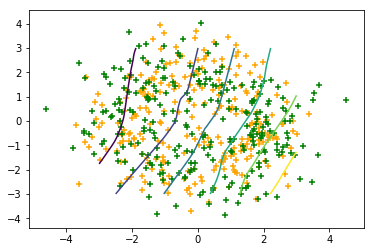

itr: 200 done
itr: 201 done
itr: 202 done
itr: 203 done
itr: 204 done
itr: 205 done
itr: 206 done
itr: 207 done
itr: 208 done
itr: 209 done
itr: 210 done
itr: 211 done
itr: 212 done
itr: 213 done
itr: 214 done
itr: 215 done
itr: 216 done
itr: 217 done
itr: 218 done
itr: 219 done
itr: 220 done
itr: 221 done
itr: 222 done
itr: 223 done
itr: 224 done
itr: 225 done
itr: 226 done
itr: 227 done
itr: 228 done
itr: 229 done
itr: 230 done
itr: 231 done
itr: 232 done
itr: 233 done
itr: 234 done
itr: 235 done
itr: 236 done
itr: 237 done
itr: 238 done
itr: 239 done
itr: 240 done
itr: 241 done
itr: 242 done
itr: 243 done
itr: 244 done
itr: 245 done
itr: 246 done
itr: 247 done
itr: 248 done
itr: 249 done
itr: 250 done
itr: 251 done
itr: 252 done
itr: 253 done
itr: 254 done
itr: 255 done
itr: 256 done
itr: 257 done
itr: 258 done
itr: 259 done
itr: 260 done
itr: 261 done
itr: 262 done
itr: 263 done
itr: 264 done
itr: 265 done
itr: 266 done
itr: 267 done
itr: 268 done
itr: 269 done
itr: 270 done
itr: 2

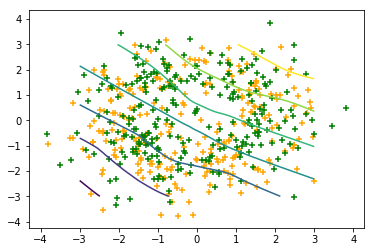

itr: 300 done
itr: 301 done
itr: 302 done
itr: 303 done
itr: 304 done
itr: 305 done
itr: 306 done
itr: 307 done
itr: 308 done
itr: 309 done
itr: 310 done
itr: 311 done
itr: 312 done
itr: 313 done
itr: 314 done
itr: 315 done
itr: 316 done
itr: 317 done
itr: 318 done
itr: 319 done
itr: 320 done
itr: 321 done
itr: 322 done
itr: 323 done
itr: 324 done
itr: 325 done
itr: 326 done
itr: 327 done
itr: 328 done
itr: 329 done
itr: 330 done
itr: 331 done
itr: 332 done
itr: 333 done
itr: 334 done
itr: 335 done
itr: 336 done
itr: 337 done
itr: 338 done
itr: 339 done
itr: 340 done
itr: 341 done
itr: 342 done
itr: 343 done
itr: 344 done
itr: 345 done
itr: 346 done
itr: 347 done
itr: 348 done
itr: 349 done
itr: 350 done
itr: 351 done
itr: 352 done
itr: 353 done
itr: 354 done
itr: 355 done
itr: 356 done
itr: 357 done
itr: 358 done
itr: 359 done
itr: 360 done
itr: 361 done
itr: 362 done
itr: 363 done
itr: 364 done
itr: 365 done
itr: 366 done
itr: 367 done
itr: 368 done
itr: 369 done
itr: 370 done
itr: 3

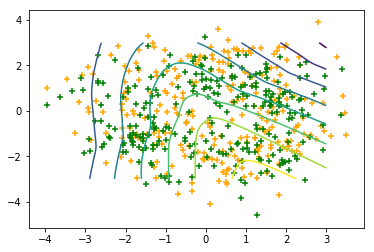

itr: 400 done
itr: 401 done
itr: 402 done
itr: 403 done
itr: 404 done
itr: 405 done
itr: 406 done
itr: 407 done
itr: 408 done
itr: 409 done
itr: 410 done
itr: 411 done
itr: 412 done
itr: 413 done
itr: 414 done
itr: 415 done
itr: 416 done
itr: 417 done
itr: 418 done
itr: 419 done
itr: 420 done
itr: 421 done
itr: 422 done
itr: 423 done
itr: 424 done
itr: 425 done
itr: 426 done
itr: 427 done
itr: 428 done
itr: 429 done
itr: 430 done
itr: 431 done
itr: 432 done
itr: 433 done
itr: 434 done
itr: 435 done
itr: 436 done
itr: 437 done
itr: 438 done
itr: 439 done
itr: 440 done
itr: 441 done
itr: 442 done
itr: 443 done
itr: 444 done
itr: 445 done
itr: 446 done
itr: 447 done
itr: 448 done
itr: 449 done
itr: 450 done
itr: 451 done
itr: 452 done
itr: 453 done
itr: 454 done
itr: 455 done
itr: 456 done
itr: 457 done
itr: 458 done
itr: 459 done
itr: 460 done
itr: 461 done
itr: 462 done
itr: 463 done
itr: 464 done
itr: 465 done
itr: 466 done
itr: 467 done
itr: 468 done
itr: 469 done
itr: 470 done
itr: 4

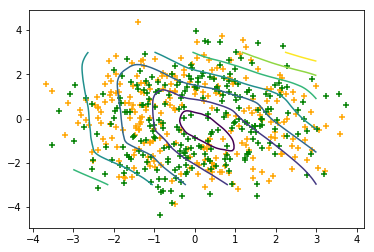

itr: 500 done
itr: 501 done
itr: 502 done
itr: 503 done
itr: 504 done
itr: 505 done
itr: 506 done
itr: 507 done
itr: 508 done
itr: 509 done
itr: 510 done
itr: 511 done
itr: 512 done
itr: 513 done
itr: 514 done
itr: 515 done
itr: 516 done
itr: 517 done
itr: 518 done
itr: 519 done
itr: 520 done
itr: 521 done
itr: 522 done
itr: 523 done
itr: 524 done
itr: 525 done
itr: 526 done
itr: 527 done
itr: 528 done
itr: 529 done
itr: 530 done
itr: 531 done
itr: 532 done
itr: 533 done
itr: 534 done
itr: 535 done
itr: 536 done
itr: 537 done
itr: 538 done
itr: 539 done
itr: 540 done
itr: 541 done
itr: 542 done
itr: 543 done
itr: 544 done
itr: 545 done
itr: 546 done
itr: 547 done
itr: 548 done
itr: 549 done
itr: 550 done
itr: 551 done
itr: 552 done
itr: 553 done
itr: 554 done
itr: 555 done
itr: 556 done
itr: 557 done
itr: 558 done
itr: 559 done
itr: 560 done
itr: 561 done
itr: 562 done
itr: 563 done
itr: 564 done
itr: 565 done
itr: 566 done
itr: 567 done
itr: 568 done
itr: 569 done
itr: 570 done
itr: 5

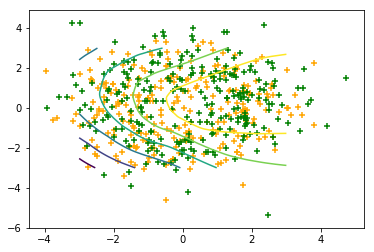

itr: 600 done
itr: 601 done
itr: 602 done
itr: 603 done
itr: 604 done
itr: 605 done
itr: 606 done
itr: 607 done
itr: 608 done
itr: 609 done
itr: 610 done
itr: 611 done
itr: 612 done
itr: 613 done
itr: 614 done
itr: 615 done
itr: 616 done
itr: 617 done
itr: 618 done
itr: 619 done
itr: 620 done
itr: 621 done
itr: 622 done
itr: 623 done
itr: 624 done
itr: 625 done
itr: 626 done
itr: 627 done
itr: 628 done
itr: 629 done
itr: 630 done
itr: 631 done
itr: 632 done
itr: 633 done
itr: 634 done
itr: 635 done
itr: 636 done
itr: 637 done
itr: 638 done
itr: 639 done
itr: 640 done
itr: 641 done
itr: 642 done
itr: 643 done
itr: 644 done
itr: 645 done
itr: 646 done
itr: 647 done
itr: 648 done
itr: 649 done
itr: 650 done
itr: 651 done
itr: 652 done
itr: 653 done
itr: 654 done
itr: 655 done
itr: 656 done
itr: 657 done
itr: 658 done
itr: 659 done
itr: 660 done
itr: 661 done
itr: 662 done
itr: 663 done
itr: 664 done
itr: 665 done
itr: 666 done
itr: 667 done
itr: 668 done
itr: 669 done
itr: 670 done
itr: 6

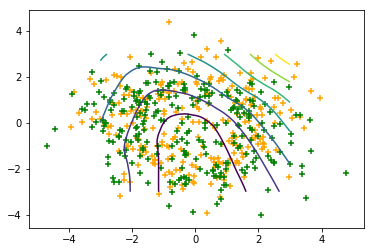

itr: 700 done
itr: 701 done
itr: 702 done
itr: 703 done
itr: 704 done
itr: 705 done
itr: 706 done
itr: 707 done
itr: 708 done
itr: 709 done
itr: 710 done
itr: 711 done
itr: 712 done
itr: 713 done
itr: 714 done
itr: 715 done
itr: 716 done
itr: 717 done
itr: 718 done
itr: 719 done
itr: 720 done
itr: 721 done
itr: 722 done
itr: 723 done
itr: 724 done
itr: 725 done
itr: 726 done
itr: 727 done
itr: 728 done
itr: 729 done
itr: 730 done
itr: 731 done
itr: 732 done
itr: 733 done
itr: 734 done
itr: 735 done
itr: 736 done
itr: 737 done
itr: 738 done
itr: 739 done
itr: 740 done
itr: 741 done
itr: 742 done
itr: 743 done
itr: 744 done
itr: 745 done
itr: 746 done
itr: 747 done
itr: 748 done
itr: 749 done
itr: 750 done
itr: 751 done
itr: 752 done
itr: 753 done
itr: 754 done
itr: 755 done
itr: 756 done
itr: 757 done
itr: 758 done
itr: 759 done
itr: 760 done
itr: 761 done
itr: 762 done
itr: 763 done
itr: 764 done
itr: 765 done
itr: 766 done
itr: 767 done
itr: 768 done
itr: 769 done
itr: 770 done
itr: 7

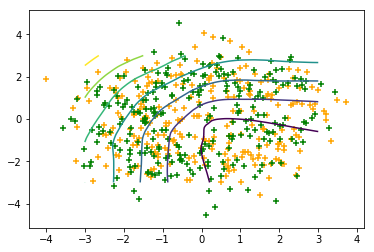

itr: 800 done
itr: 801 done
itr: 802 done
itr: 803 done
itr: 804 done
itr: 805 done
itr: 806 done
itr: 807 done
itr: 808 done
itr: 809 done
itr: 810 done
itr: 811 done
itr: 812 done
itr: 813 done
itr: 814 done
itr: 815 done
itr: 816 done
itr: 817 done
itr: 818 done
itr: 819 done
itr: 820 done
itr: 821 done
itr: 822 done
itr: 823 done
itr: 824 done
itr: 825 done
itr: 826 done
itr: 827 done
itr: 828 done
itr: 829 done
itr: 830 done
itr: 831 done
itr: 832 done
itr: 833 done
itr: 834 done
itr: 835 done
itr: 836 done
itr: 837 done
itr: 838 done
itr: 839 done
itr: 840 done
itr: 841 done
itr: 842 done
itr: 843 done
itr: 844 done
itr: 845 done
itr: 846 done
itr: 847 done
itr: 848 done
itr: 849 done
itr: 850 done
itr: 851 done
itr: 852 done
itr: 853 done
itr: 854 done
itr: 855 done
itr: 856 done
itr: 857 done
itr: 858 done
itr: 859 done
itr: 860 done
itr: 861 done
itr: 862 done
itr: 863 done
itr: 864 done
itr: 865 done
itr: 866 done
itr: 867 done
itr: 868 done
itr: 869 done
itr: 870 done
itr: 8

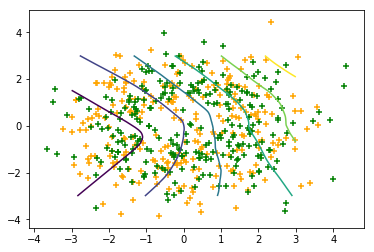

itr: 900 done
itr: 901 done
itr: 902 done
itr: 903 done
itr: 904 done
itr: 905 done
itr: 906 done
itr: 907 done
itr: 908 done
itr: 909 done
itr: 910 done
itr: 911 done
itr: 912 done
itr: 913 done
itr: 914 done
itr: 915 done
itr: 916 done
itr: 917 done
itr: 918 done
itr: 919 done
itr: 920 done
itr: 921 done
itr: 922 done
itr: 923 done
itr: 924 done
itr: 925 done
itr: 926 done
itr: 927 done
itr: 928 done
itr: 929 done
itr: 930 done
itr: 931 done
itr: 932 done
itr: 933 done
itr: 934 done
itr: 935 done
itr: 936 done
itr: 937 done
itr: 938 done
itr: 939 done
itr: 940 done
itr: 941 done
itr: 942 done
itr: 943 done
itr: 944 done
itr: 945 done
itr: 946 done
itr: 947 done
itr: 948 done
itr: 949 done
itr: 950 done
itr: 951 done
itr: 952 done
itr: 953 done
itr: 954 done
itr: 955 done
itr: 956 done
itr: 957 done
itr: 958 done
itr: 959 done
itr: 960 done
itr: 961 done
itr: 962 done
itr: 963 done
itr: 964 done
itr: 965 done
itr: 966 done
itr: 967 done
itr: 968 done
itr: 969 done
itr: 970 done
itr: 9

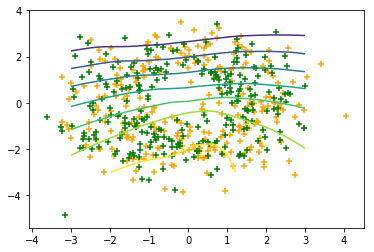

itr: 1000 done


In [17]:
## dont touch unless you want to train
for itr in range(TOT_GEN_ITR):
    ## D training and hence layers paprams should get updated.
    for p in D.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update

    for iter_d in range(DISCRI_ITR):
        #print(iter_d)
        _data = next(d)
        real_data = torch.Tensor(_data)
        real_data = real_data.cuda()
        real_data_v = agd.Variable(real_data)
        #print(real_data_v)

        D.zero_grad()

        # train with real
        D_real = D(real_data_v)
        D_real = D_real.mean()
        D_real.backward(onebar)

        # train with fake
        noise = torch.randn(BATCHSZ, 2)
        noise = noise.cuda()
        noisev = agd.Variable(noise, volatile=True)  # totally freeze netG
        
        #noisev = agd.Variable(noise)
        gop = G(noisev, real_data_v)
        #print('here3')
        fake = agd.Variable(gop.data)
        inputv = fake
        D_fake = D(inputv)
        D_fake = D_fake.mean()
        D_fake.backward(one)

        # train with gradient penalty
        gradient_penalty = calc_gp(D, real_data_v.data, fake.data)
        gradient_penalty.backward()

        D_cost = D_fake - D_real + gradient_penalty
        Wasserstein_D = D_real - D_fake
        optD.step()
        #print('discri iter done ', iter_d)

    if not FIXED_GEN:
        #now the discriminator should not be updating it's weights
        for p in D.parameters():
            p.requires_grad = False  # to avoid computation
        G.zero_grad()

        _data = next(d)
        real_data = torch.Tensor(_data)
        real_data = real_data.cuda()
        real_data_v = agd.Variable(real_data)

        noise = torch.randn(BATCHSZ, 2)
        noise = noise.cuda()
        noisev = agd.Variable(noise)
        fake = G(noisev, real_data_v)
        g_ = D(fake)
        g_ = g_.mean()
        g_.backward(onebar)
        G_cost = -g_
        optG.step()
    print('itr: {} done'.format(itr))
    # Write logs and save samples
    #lib.plot.plot('tmp/' + DATASET + '/' + 'disc cost', D_cost.cpu().data.numpy())
    #lib.plot.plot('tmp/' + DATASET + '/' + 'wasserstein distance', Wasserstein_D.cpu().data.numpy())
    if not FIXED_GEN:
        #lib.plot.plot('tmp/' + DATASET + '/' + 'gen cost', G_cost.cpu().data.numpy())
        if itr % 100 == 99:
        #lib.plot.flush()
            generate_image(_data)
        #lib.plot.tick()

## testing on the far away, differently oriented gaussians (triplets)

In [12]:
def triplegauss_gen():
    c1 = np.array([0,0])*2
    c2 = np.array([5,5])*2
    c3 = np.array([7,-14])*2
    s1 = np.array([[1,0],[0,6]])
    s2 = np.array([[6,0],[0,2]])
    s3 = np.array([[2,10],[7,6]])
    g = GMMsampler(batchSz, n_components=3, weights=[1, 1, 1],
                  mu=[c1,c2,c3], sig=[s1,s2,s3])
    while(True):
        g.gen_sample()
#         g.plot_centers()
#         g.plot_data()
        yield g.data
dtriple = triplegauss_gen()

/home/udion/Misc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.


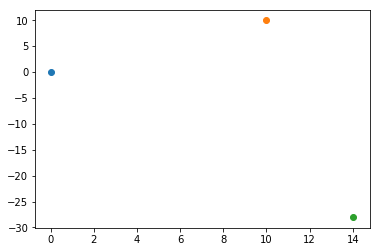

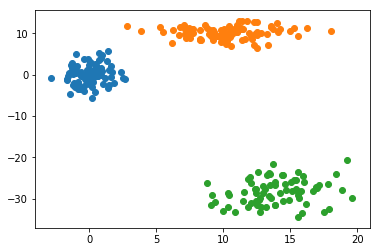

array([[  1.23813583e+01,  -2.75770742e+01],
       [ -1.22934859e+00,   1.48561089e+00],
       [  1.30061946e+01,  -2.68174949e+01],
       [  2.10909694e-01,   9.09969484e-01],
       [  1.05980491e+01,   6.82722279e+00],
       [  5.25213767e+00,   1.16219661e+01],
       [ -3.95222094e-01,  -2.61788327e+00],
       [ -1.07737960e+00,  -3.00426979e+00],
       [  1.54516268e+01,  -2.76043314e+01],
       [  1.43549668e+00,   5.80073627e+00],
       [  1.58999829e+01,  -3.33771803e+01],
       [  9.11078099e+00,   9.23564266e+00],
       [  2.34609469e+00,   6.00161535e-01],
       [  1.51954612e+00,  -2.56652616e+00],
       [  8.86264571e-01,   1.57494066e+00],
       [  1.33901574e+01,  -2.37243094e+01],
       [  1.18688017e+01,  -2.51971163e+01],
       [  1.01965403e+01,   7.43756402e+00],
       [ -2.60869735e-01,  -3.70968826e-01],
       [  1.57791245e+01,  -2.80496555e+01],
       [  1.36835530e+01,   1.11229719e+01],
       [  8.78550403e+00,   1.11923616e+01],
       [  

In [53]:
next(dtriple)

/home/udion/Misc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.


itr: 0 done
itr: 50 done
showing a graph


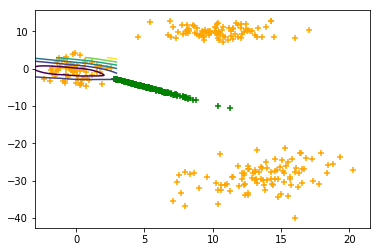

itr: 100 done
itr: 150 done
showing a graph


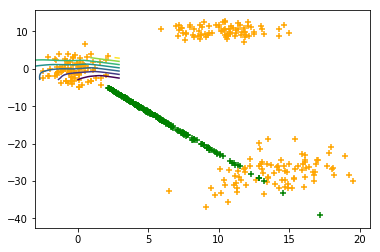

itr: 200 done
itr: 250 done
showing a graph


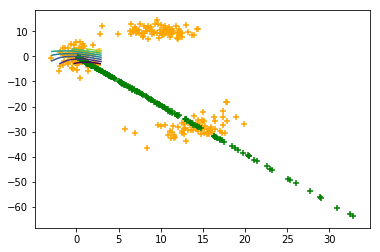

itr: 300 done
itr: 350 done
showing a graph


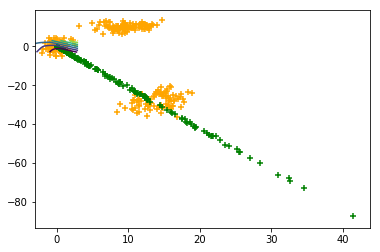

itr: 400 done
itr: 450 done
showing a graph


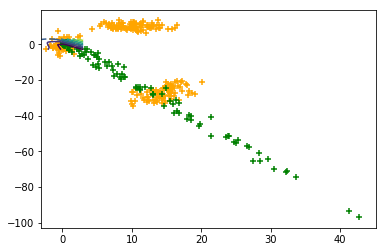

itr: 500 done
itr: 550 done
showing a graph


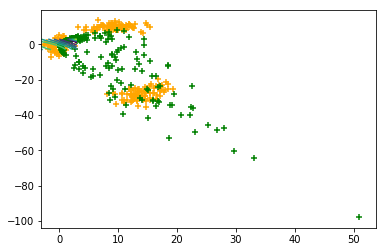

itr: 600 done
itr: 650 done
showing a graph


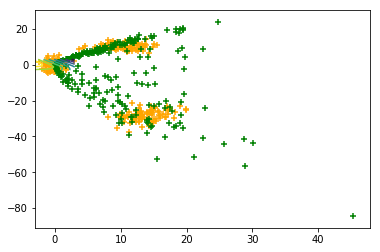

itr: 700 done
itr: 750 done
showing a graph


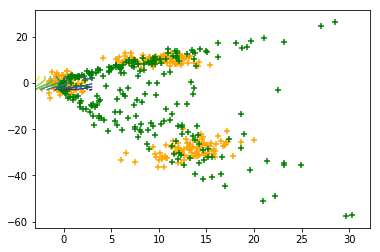

itr: 800 done
itr: 850 done
showing a graph


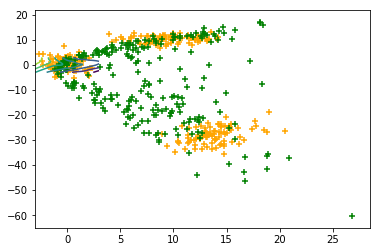

itr: 900 done
itr: 950 done
showing a graph


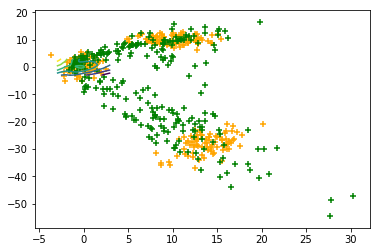

itr: 1000 done
itr: 1050 done
showing a graph


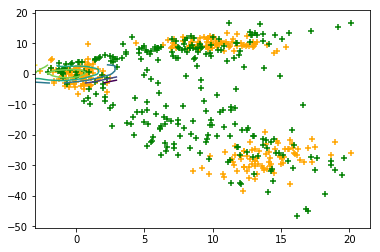

itr: 1100 done
itr: 1150 done
showing a graph


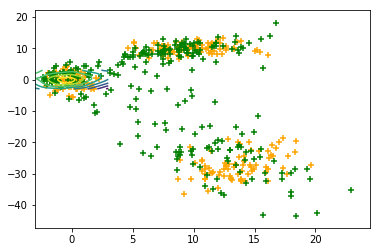

itr: 1200 done
itr: 1250 done
showing a graph


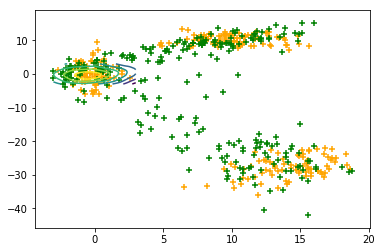

itr: 1300 done
itr: 1350 done
showing a graph


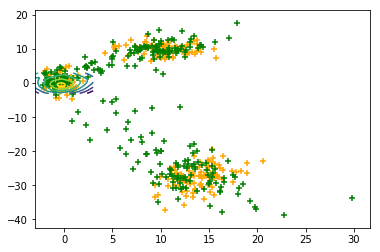

itr: 1400 done
itr: 1450 done
showing a graph


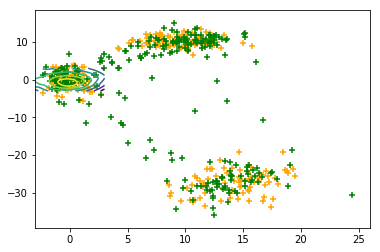

itr: 1500 done
itr: 1550 done
showing a graph


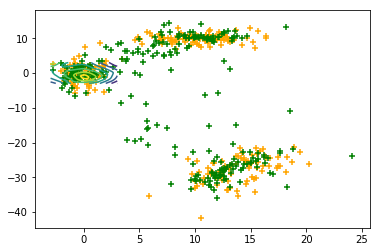

itr: 1600 done
itr: 1650 done
showing a graph


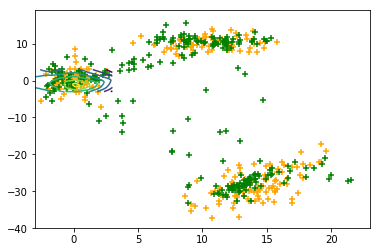

itr: 1700 done
itr: 1750 done
showing a graph


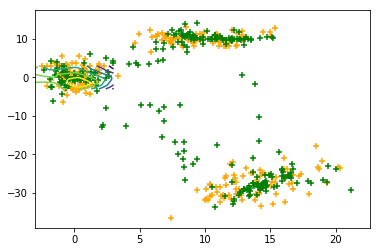

itr: 1800 done
itr: 1850 done
showing a graph


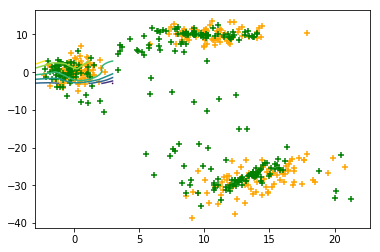

itr: 1900 done
itr: 1950 done
showing a graph


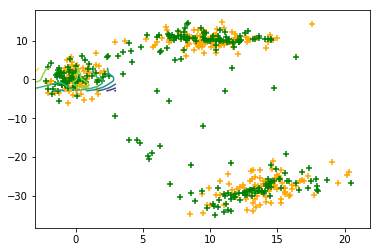

itr: 2000 done
itr: 2050 done
showing a graph


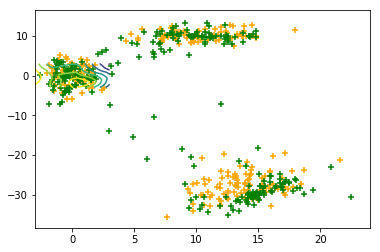

itr: 2100 done
itr: 2150 done
showing a graph


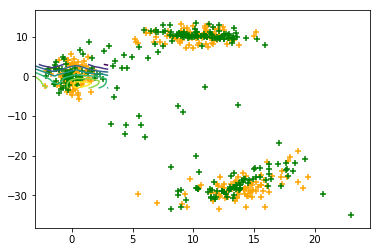

itr: 2200 done
itr: 2250 done
showing a graph


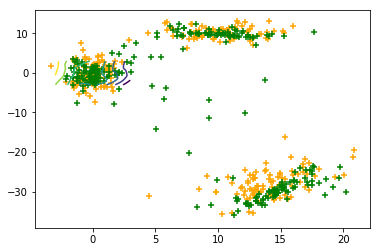

itr: 2300 done
itr: 2350 done
showing a graph


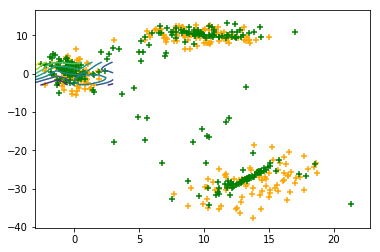

itr: 2400 done
itr: 2450 done
showing a graph


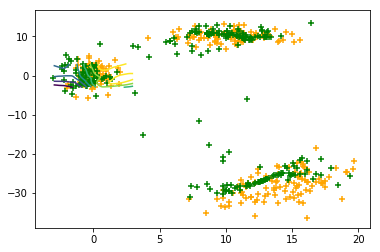

itr: 2500 done
itr: 2550 done
showing a graph


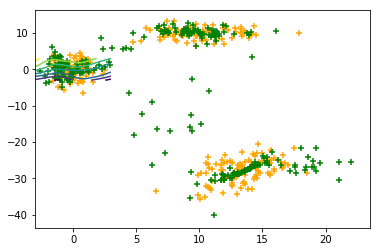

itr: 2600 done
itr: 2650 done
showing a graph


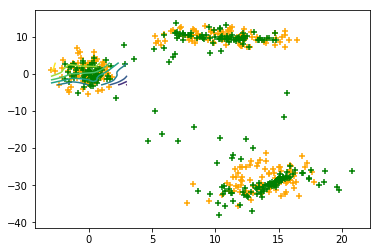

itr: 2700 done
itr: 2750 done
showing a graph


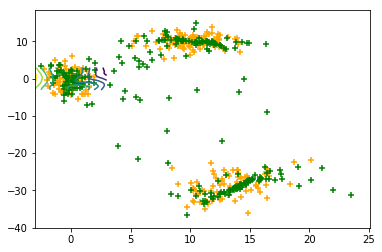

itr: 2800 done
itr: 2850 done
showing a graph


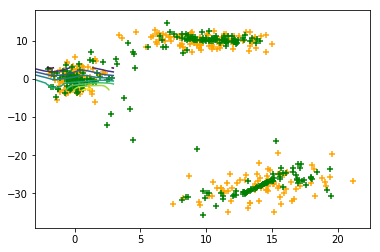

itr: 2900 done
itr: 2950 done
showing a graph


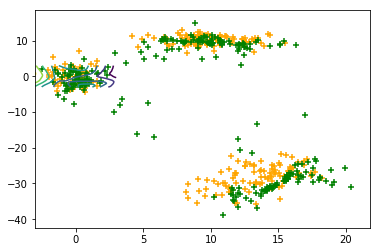

itr: 3000 done
itr: 3050 done
showing a graph


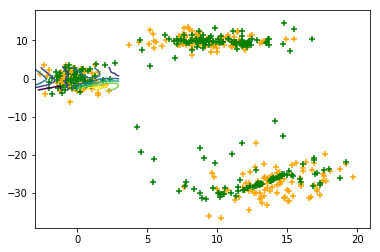

itr: 3100 done
itr: 3150 done
showing a graph


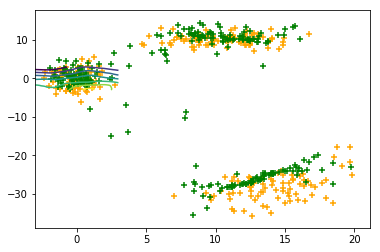

itr: 3200 done
itr: 3250 done
showing a graph


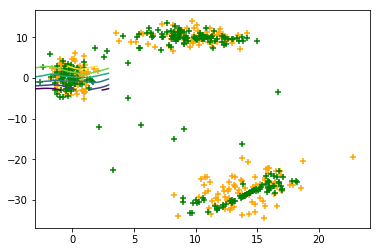

itr: 3300 done
itr: 3350 done
showing a graph


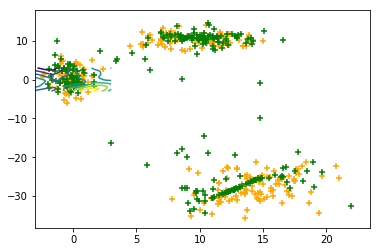

itr: 3400 done
itr: 3450 done
showing a graph


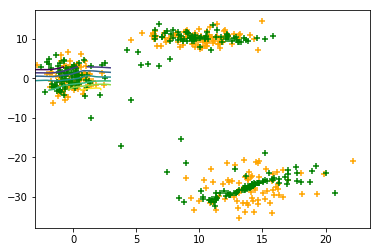

itr: 3500 done
itr: 3550 done
showing a graph


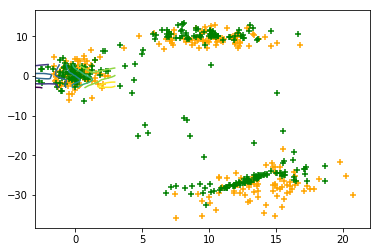

itr: 3600 done
itr: 3650 done
showing a graph


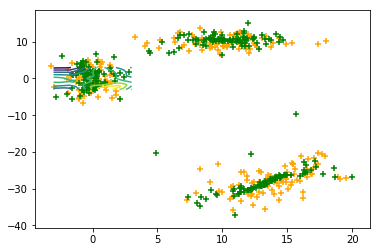

itr: 3700 done
itr: 3750 done
showing a graph


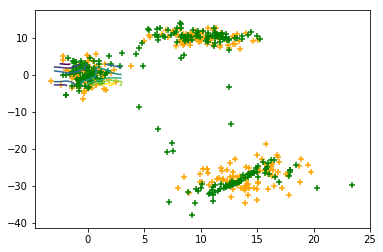

itr: 3800 done
itr: 3850 done
showing a graph


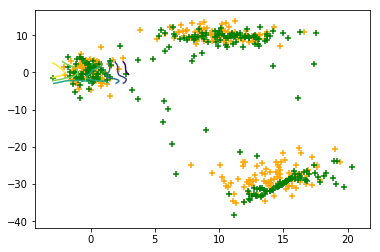

itr: 3900 done
itr: 3950 done
showing a graph


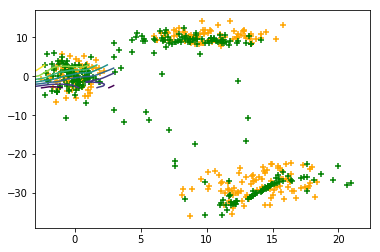

itr: 4000 done
itr: 4050 done
showing a graph


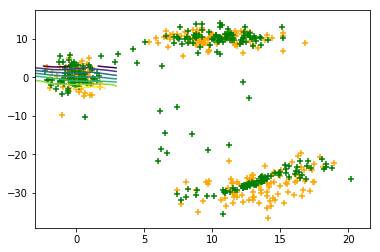

itr: 4100 done
itr: 4150 done
showing a graph


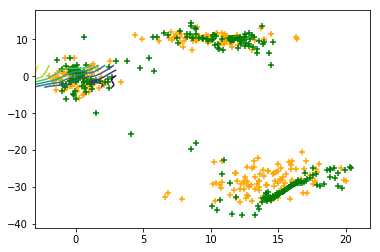

itr: 4200 done
itr: 4250 done
showing a graph


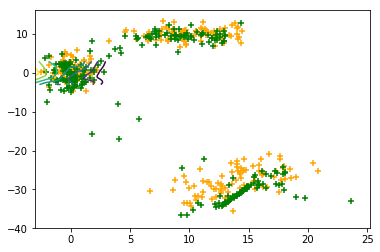

itr: 4300 done
itr: 4350 done
showing a graph


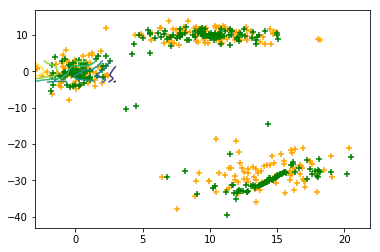

itr: 4400 done
itr: 4450 done
showing a graph


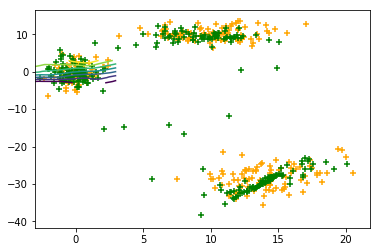

itr: 4500 done
itr: 4550 done
showing a graph


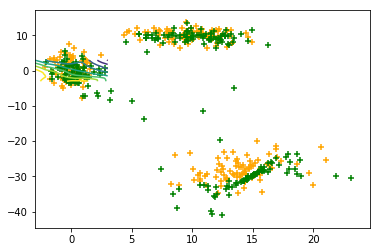

itr: 4600 done
itr: 4650 done
showing a graph


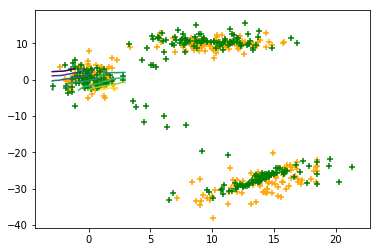

itr: 4700 done
itr: 4750 done
showing a graph


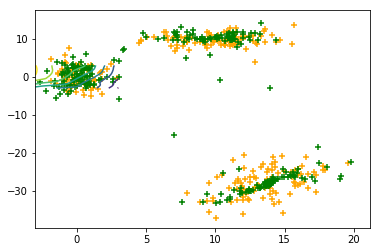

itr: 4800 done
itr: 4850 done
showing a graph


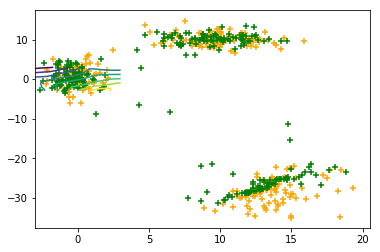

itr: 4900 done
itr: 4950 done
showing a graph


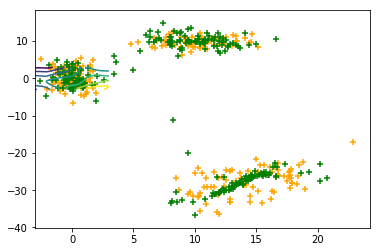

itr: 5000 done
itr: 5050 done
showing a graph


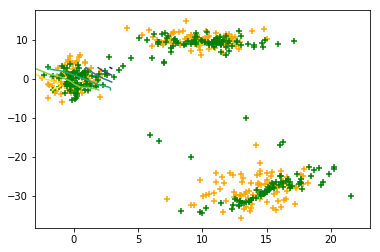

itr: 5100 done
itr: 5150 done
showing a graph


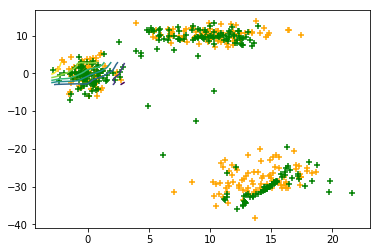

itr: 5200 done
itr: 5250 done
showing a graph


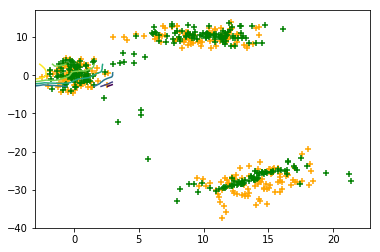

itr: 5300 done
itr: 5350 done
showing a graph


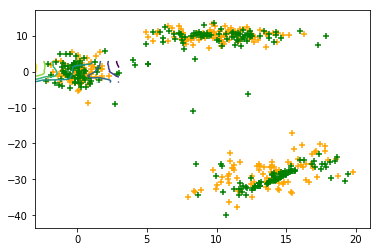

itr: 5400 done
itr: 5450 done
showing a graph


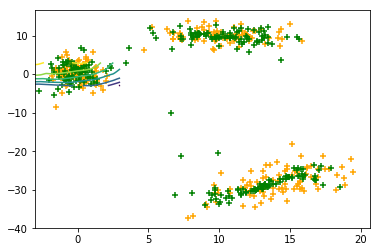

itr: 5500 done
itr: 5550 done
showing a graph


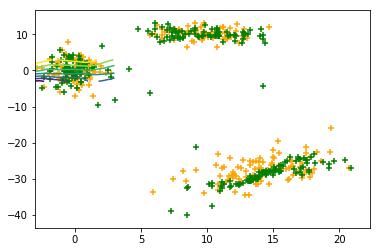

itr: 5600 done
itr: 5650 done
showing a graph


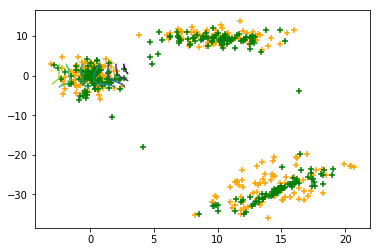

itr: 5700 done
itr: 5750 done
showing a graph


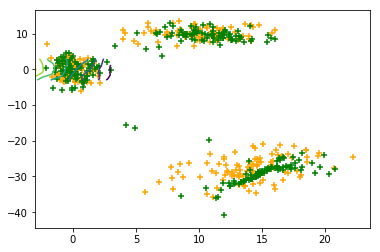

itr: 5800 done
itr: 5850 done
showing a graph


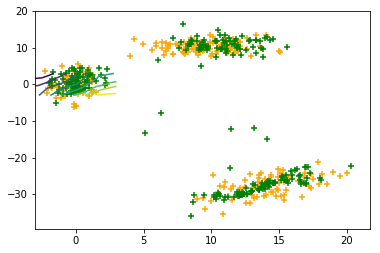

itr: 5900 done
itr: 5950 done
showing a graph


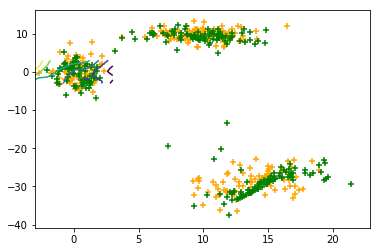

itr: 6000 done
itr: 6050 done
showing a graph


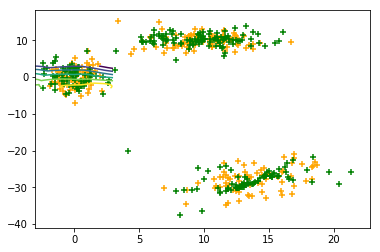

itr: 6100 done
itr: 6150 done
showing a graph


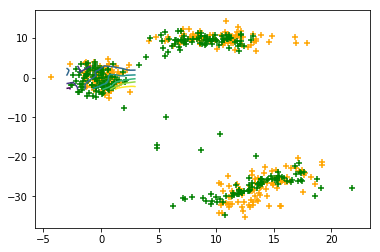

itr: 6200 done
itr: 6250 done
showing a graph


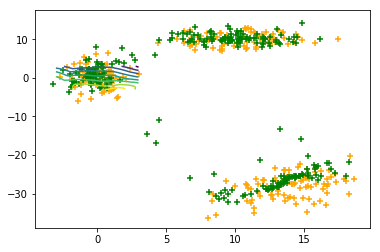

itr: 6300 done
itr: 6350 done
showing a graph


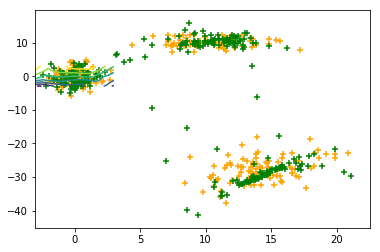

itr: 6400 done
itr: 6450 done
showing a graph


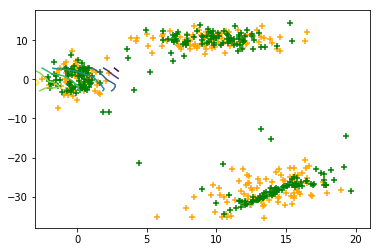

itr: 6500 done
itr: 6550 done
showing a graph


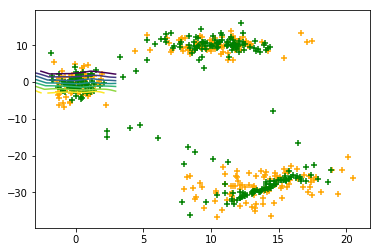

itr: 6600 done
itr: 6650 done
showing a graph


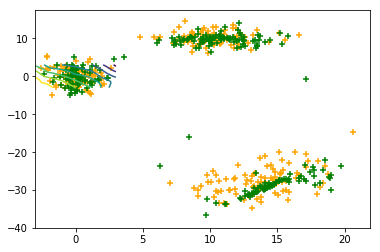

itr: 6700 done
itr: 6750 done
showing a graph


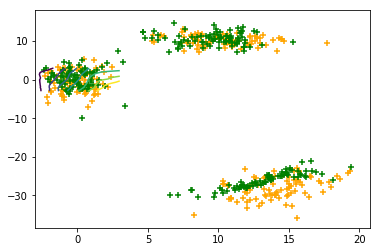

itr: 6800 done
itr: 6850 done
showing a graph


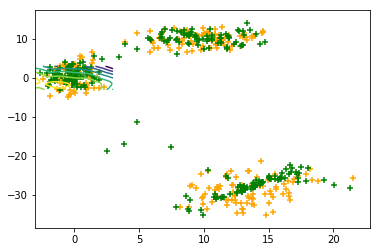

itr: 6900 done
itr: 6950 done
showing a graph


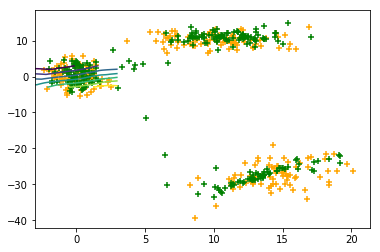

itr: 7000 done
itr: 7050 done
showing a graph


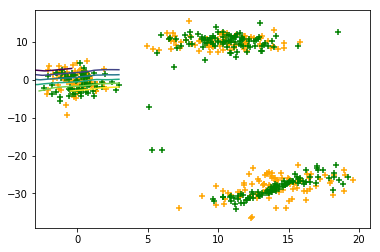

itr: 7100 done
itr: 7150 done
showing a graph


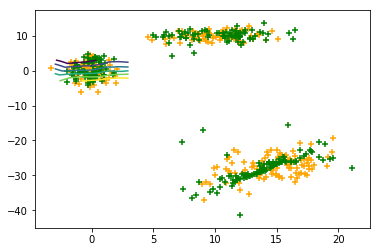

itr: 7200 done
itr: 7250 done
showing a graph


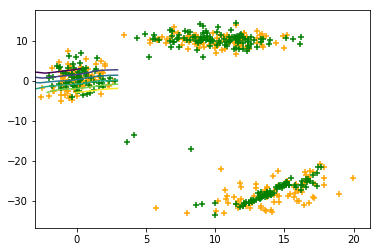

itr: 7300 done
itr: 7350 done
showing a graph


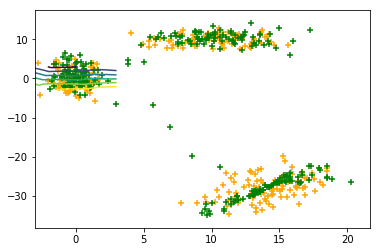

itr: 7400 done
itr: 7450 done
showing a graph


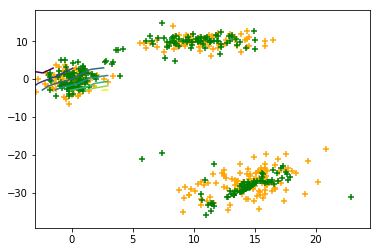

itr: 7500 done
itr: 7550 done
showing a graph


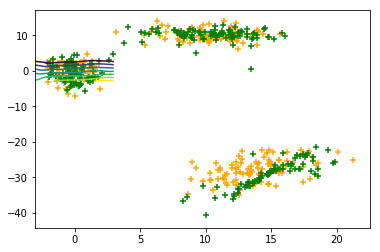

itr: 7600 done
itr: 7650 done
showing a graph


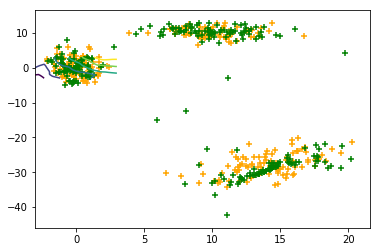

itr: 7700 done
itr: 7750 done
showing a graph


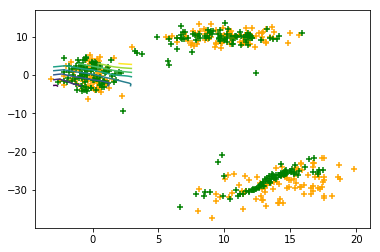

itr: 7800 done
itr: 7850 done
showing a graph


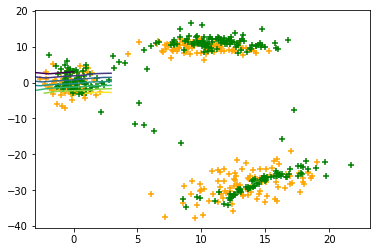

itr: 7900 done
itr: 7950 done
showing a graph


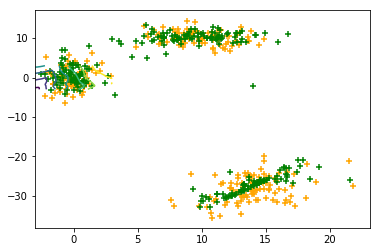

itr: 8000 done
itr: 8050 done
showing a graph


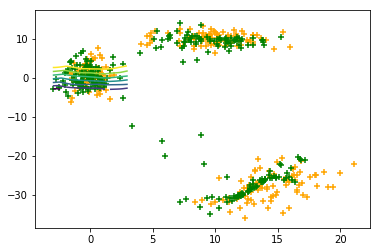

itr: 8100 done
itr: 8150 done
showing a graph


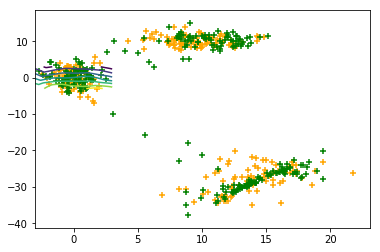

itr: 8200 done
itr: 8250 done
showing a graph


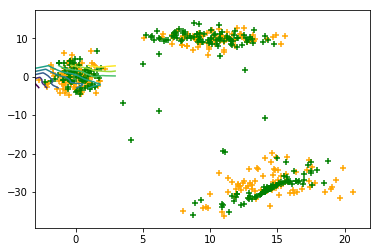

itr: 8300 done
itr: 8350 done
showing a graph


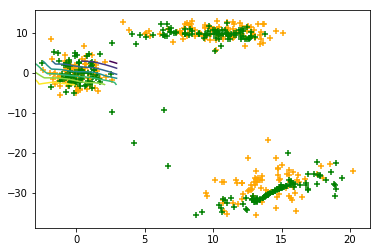

itr: 8400 done
itr: 8450 done
showing a graph


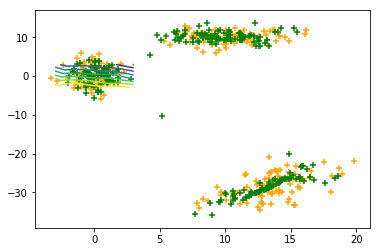

itr: 8500 done
itr: 8550 done
showing a graph


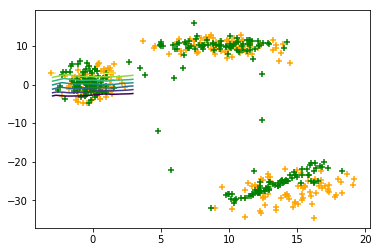

itr: 8600 done
itr: 8650 done
showing a graph


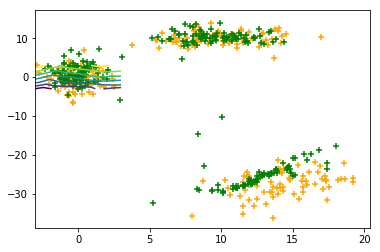

itr: 8700 done
itr: 8750 done
showing a graph


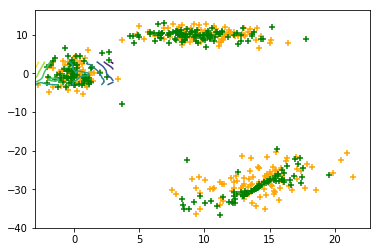

itr: 8800 done
itr: 8850 done
showing a graph


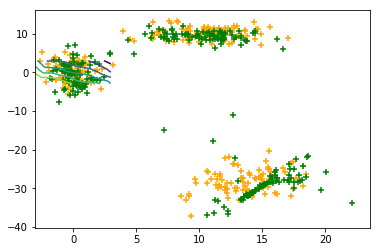

itr: 8900 done
itr: 8950 done
showing a graph


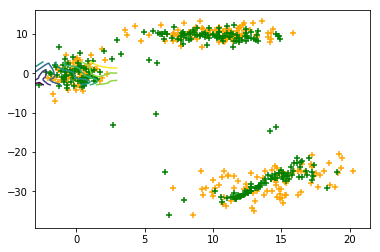

itr: 9000 done
itr: 9050 done
showing a graph


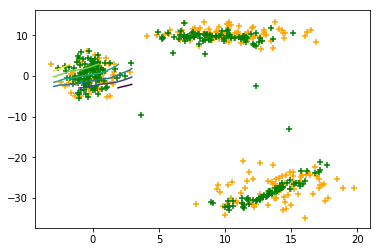

itr: 9100 done
itr: 9150 done
showing a graph


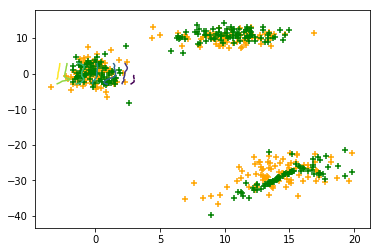

itr: 9200 done
itr: 9250 done
showing a graph


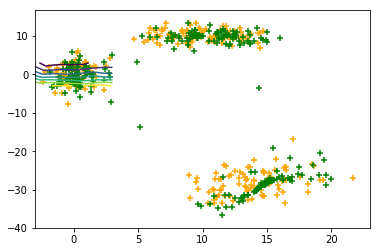

itr: 9300 done
itr: 9350 done
showing a graph


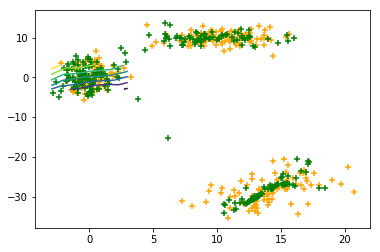

itr: 9400 done
itr: 9450 done
showing a graph


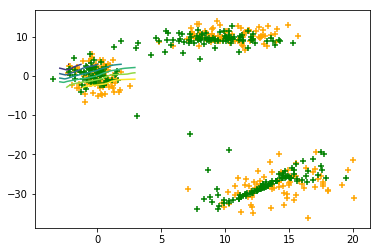

itr: 9500 done
itr: 9550 done
showing a graph


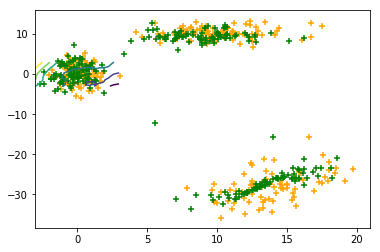

itr: 9600 done
itr: 9650 done
showing a graph


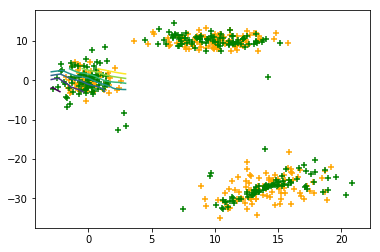

itr: 9700 done
itr: 9750 done
showing a graph


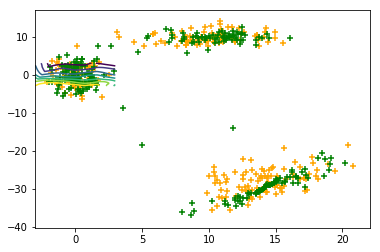

itr: 9800 done
itr: 9850 done
showing a graph


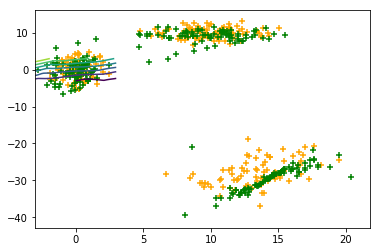

itr: 9900 done
itr: 9950 done
showing a graph


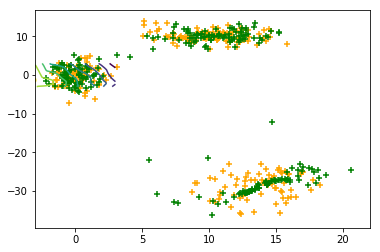

In [13]:
## dont touch unless you want to train
for itr in range(10000):
    ## D training and hence layers paprams should get updated.
    for p in D.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update

    for iter_d in range(DISCRI_ITR):
        #print(iter_d)
        _data = next(dtriple)
        real_data = torch.Tensor(_data)
        real_data = real_data.cuda()
        real_data_v = agd.Variable(real_data)
        #print(real_data_v)

        D.zero_grad()

        # train with real
        D_real = D(real_data_v)
        D_real = D_real.mean()
        D_real.backward(onebar)

        # train with fake
        noise = torch.randn(BATCHSZ, 2)
        noise = noise.cuda()
        noisev = agd.Variable(noise, volatile=True)  # totally freeze netG
        
        #noisev = agd.Variable(noise)
        gop = G(noisev, real_data_v)
        #print('here3')
        fake = agd.Variable(gop.data)
        inputv = fake
        D_fake = D(inputv)
        D_fake = D_fake.mean()
        D_fake.backward(one)

        # train with gradient penalty
        gradient_penalty = calc_gp(D, real_data_v.data, fake.data)
        gradient_penalty.backward()

        D_cost = D_fake - D_real + gradient_penalty
        Wasserstein_D = D_real - D_fake
        optD.step()
        #print('discri iter done ', iter_d)

    if not FIXED_GEN:
        #now the discriminator should not be updating it's weights
        for p in D.parameters():
            p.requires_grad = False  # to avoid computation
        G.zero_grad()

        _data = next(dtriple)
        real_data = torch.Tensor(_data)
        real_data = real_data.cuda()
        real_data_v = agd.Variable(real_data)

        noise = torch.randn(BATCHSZ, 2)
        noise = noise.cuda()
        noisev = agd.Variable(noise)
        fake = G(noisev, real_data_v)
        g_ = D(fake)
        g_ = g_.mean()
        g_.backward(onebar)
        G_cost = -g_
        optG.step()
    if itr%50 == 0:
        print('itr: {} done'.format(itr))
    # Write logs and save samples
    #lib.plot.plot('tmp/' + DATASET + '/' + 'disc cost', D_cost.cpu().data.numpy())
    #lib.plot.plot('tmp/' + DATASET + '/' + 'wasserstein distance', Wasserstein_D.cpu().data.numpy())
    if not FIXED_GEN:
        #lib.plot.plot('tmp/' + DATASET + '/' + 'gen cost', G_cost.cpu().data.numpy())
        if itr % 100 == 99:
        #lib.plot.flush()
            generate_image(_data)
        #lib.plot.tick()